In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
%matplotlib inline

# MINST Dataset

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

mnist => is 784 = 28*28 pixel

In [6]:
type(X)

pandas.core.frame.DataFrame

5


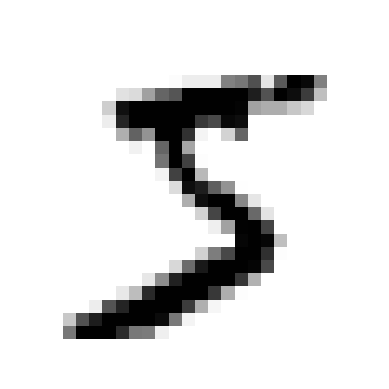

In [7]:
some_digit = X.iloc[0].values.reshape(28, -1)
plt.imshow(some_digit, cmap="binary")
plt.axis("off")
print(y[0])

In [8]:
type(y)

pandas.core.series.Series

In [9]:
# y => is categories list
# let's convert it to numbers
y = y.astype(np.uint8)
# MINST Is already splitted into train (6000), test
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

**it's already shuffled** => some training algorithms is sensetive if get simialr examples in row

# Binary Classifier

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
# Stochastic (randomness) Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # set random state to reproducible results because it's higly depend on it
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

# Performance Measures
measure performance for classifiers is much trickier than regression


## Measuring Accuracy Using Cross-Validation


In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    X_train_fold, y_train_fold = X_train.iloc[train_index], y_train_5.iloc[train_index]
    X_test_fold, y_test_fold = X_train.iloc[test_index], y_train_5.iloc[test_index]

    clone_clf = clone(sgd_clf)
    clone_clf.fit(X_train_fold, y_train_fold)

    y_pred = clone_clf.predict(X_test_fold)
    n_correct = np.sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

**Actually:** if We only predict _zeros_ we will get more than 90% accuracy
because dataset is biased

## Confusion Matrix

In [14]:
# lets get cross-validation predication
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) # y_true, y_pred
# return => True_negative, False_positive, false negative, true positive

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
y_train_perfect_pred = y_train_5
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Two meertices to understand more:
1. **Precision** (accuracy of positive predications)
    > we can maxmize percision by just predict one sample true as true and give all others as zero 

   $$ \text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
   $$

2. **Recall** (senstivity)(TRP (true positive rate))
   > percentage of true positive instances that predicted correctly
   
   $$ \text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
   $$
![confusionMatrix](./imgs/confusionMatrix.png)

## Precision & Recall

In [17]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


can combine two in one metric __F1 Score__ where it express haramonic mean of precision and recall. \
difference between _mean_ and _haramonic mean_ is mean give equal weight to all __but__  haramonic mean give much more wieght to low value

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} 
$$
\
\
$$
F_1 = 2 \frac{precision * recall}{precision + recall}
$$
\
\
$$
F_1 = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [19]:
y_scores = sgd_clf.decision_function([some_digit.flatten()])
y_scores

C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [20]:
threshold = 0 
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [21]:
threshold = 8000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

Increasing thresholding __decrease RECALL__ 
\
\
__high recall:__ 
- will predict some negatives as postives
- how confident/safe I am for regecting predications
- maxmize when I predict all samples as positives ___(FN = 0)___
- eg., trained classifier to detect shoplifter in survillence images
\
\
__high precision:__
- will predict some postives as negatives
- how confident/safe I am for my positive predications
- maxmize when I predict all samples as negatives ___(FP = 0)___ ^ except one as  TP
- eg., trained classifier to detect videos that are safe for the kids

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [23]:
from sklearn.metrics import precision_recall_curve

In [24]:
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

In [25]:
def plot_precision_recall_vs_threshold(precision, recall, thresholds):
    plt.figure(figsize=(16, 5), dpi=1200)
    plt.plot(thresholds, precision[:-1],  "b--",  label="precision")
    plt.plot(thresholds, recall[:-1], "g-", label="recall")
    plt.xlabel("Threshold")
    plt.xlim((-50000, 50000))
    plt.legend()
    plt.grid()
plot_precision_recall_vs_threshold(precision, recall, thresholds)

it's normal for precision to be bumpier don't worry [Not a case with recall]

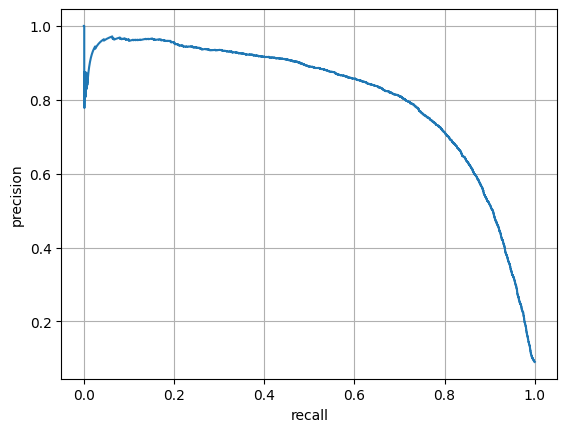

In [26]:
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.grid()

- precision start to fall out sharply @ 0.8
- what if I want want precision around 90% then I want lowest threshold that will do

In [27]:
threshold_90_precision = thresholds[np.argmax(precision >= 0.9)]
threshold_90_precision

3370.0194991439557

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


## The ROC Curve

the reciver operating characteristic (ROC) is another common tool for binary classification. \
it's like precision/recall curve but instead plotting TPR vs. FPR. \
__TRP:__ (recall)(senstivity) = $\frac{TP}{\text{all pos samples}}$ = $\frac{TP}{TP + FN}$. \
__TNR:__ (specificity) = $\frac{TN}{\text{all neg samples}}$ = $\frac{TN}{TN + FP}$. \
__FPR:__ = $\frac{FP}{\text{all neg samples}}$ = $\frac{FP}{FP + TN}$ = $1 - TNR$  = $1 - \text{specificity}$. \
\
\
ROC Curve plot how much I predict positive correct how (TRP) vs.  how much I predict negative samples as pos(1 - TNR)

In [29]:
from sklearn.metrics import roc_curve

In [62]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [63]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0., 1.], [0., 1.,], 'k--')
    plt.grid()
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (recall)")

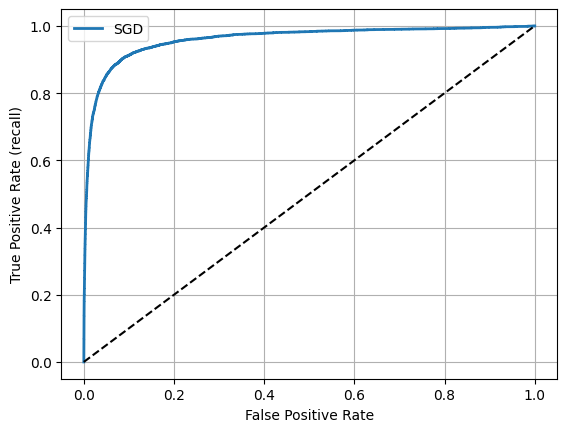

In [66]:
plot_roc_curve(fpr, tpr, "SGD")

- the dotted line represent purely random classifier with (50% chance to get positive ^ negative true)
- the good classifer stays as far 
away from that line as possibl (like most top-left) \
\
* here I can choose one with recall (TPR) 40% with FPR nearly to zero
* actually that's very bad as theis mean it could predict that 40% percent of 5s (5421 img) and rest is false (60000 - 5421)e

**One Way to compare classifiers** is using the area under the curve of ROC curve

In [33]:
from sklearn.metrics import roc_auc_score

In [34]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### When to use ROC vs PR curve
__Rule of thumb:__ 
- Favor "PR Curve" when postive cases are rare || (care about False Positives > care about False Negative)
- otherwise => ROC
  
eg.,
- above ROC curve could make you assume it do well where it actually bad as there's only (approx 5400) positive.
- In contrast, the PR curve makes it clear that the classifier has 
room for improvement (the curve could be closer to the top-left corner).

### Compare Models (ROC AUC)

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
forest_clf = RandomForestClassifier(random_state=42)

In [37]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [57]:
y_probas_forest # predict_neg, predict_pos

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [68]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

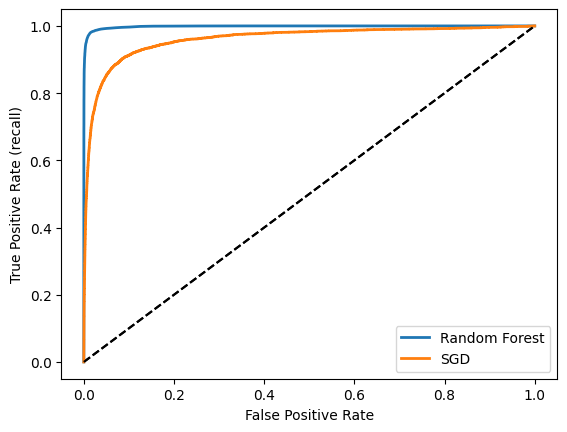

In [69]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr, tbr, "SGD")

In [70]:
print("AUC ROC Random Forest: ", roc_auc_score(y_train_5, y_scores_forest))
print("AUC ROC SGD: ", roc_auc_score(y_train_5, y_scores))

AUC ROC Random Forest:  0.9983436731328145
AUC ROC SGD:  0.9604938554008616


In [73]:
print("Random Forest prescision:\t", precision_score(y_train_5, y_scores_forest >= 0.5))
print("Random Forest recall:\t", recall_score(y_train_5, y_scores_forest >= 0.5))

Random Forest prescision:	 0.9897468089558485
Random Forest recall:	 0.8725327430363402


# Finale

## How to train binary classifier
1. choose appropriate metrics for your task
2. evaluate your classifier using cross-validation
3. select precision/recall trade-off fits your needs
4. use ROC, ROC AUC scores to compare between models 